In [22]:
%load_ext lab_black

import pandas as pd
import geopandas as gpd
import ee
from geopandas.tools import sjoin
from shapely.geometry import Point
from geopandas.tools import sjoin
from shapely.geometry import Point

cols_i = [
    "identifier",
    "modified",
    "references",
    "catalogNumber",
    "individualCount",
    "eventDate",
    "eventTime",
    "locality",
    "decimalLatitude",
    "decimalLongitude",
    "scientificName",
    "higherClassification",
    "taxonKey",
    "speciesKey",
    "genericName",
    "acceptedScientificName",
    "verbatimScientificName",
    "level2Name",
]

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [15]:
df = pd.read_hdf("/data/projects/hackaton-2020/observations.hdf", "key")

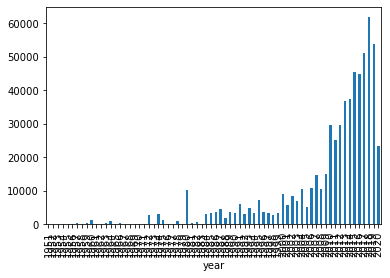

In [16]:
df = df[~pd.isna(df.eventDate)]
df = df[df.eventDate.str.slice(0, 4).astype(int) > 1950]
df["event_date"] = pd.to_datetime([t.split("T")[0] for t in df.eventDate])
df["year"] = df.eventDate.str.slice(0, 4).astype(int)
df.groupby(df.year).count().identifier.plot.bar()

In [18]:
df.shape

(623238, 20)

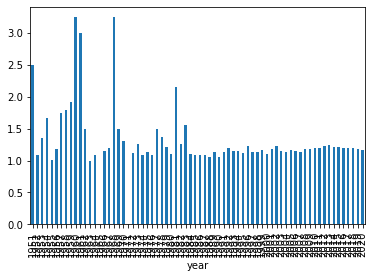

In [23]:
df_species = pd.read_csv("/data/projects/hackaton-2020/species.csv", sep=";")
df_species = df_species[["Wetenschappelijke naam", "Zeldzaamheid", "Soortgroep"]]
df_species.columns = ["name", "rarity", "species_type"]
df_m = pd.merge(
    df, df_species, how="left", left_on=["verbatimScientificName"], right_on=["name"]
)
df_m.groupby(df_m.year).mean().rarity.plot.bar()

In [24]:
df_evi = pd.read_csv("../data/satdata/evi.csv")
buurten = gpd.read_file("../data/shape/breda_buurten.shp")
buurten = buurten.to_crs(epsg=4326)  # to lat-lon
points = [Point(xy) for xy in zip(df.decimalLongitude, df.decimalLatitude)]
df_geo = gpd.GeoDataFrame(crs="epsg:4326", geometry=points)
df_joined = sjoin(df_geo, buurten)
df_joined["year"] = df_m.loc[df_joined.index].year
df_joined["obs_rarity"] = df_m.loc[df_joined.index].rarity
df_joined["species_type"] = df_m.loc[df_joined.index].species_type

In [25]:
points = [Point(xy) for xy in zip(df.decimalLongitude, df.decimalLatitude)]
df_geo = gpd.GeoDataFrame(crs="epsg:4326", geometry=points)
df_joined = sjoin(df_geo, buurten)
df_joined["year"] = df_m.loc[df_joined.index].year
df_joined["obs_rarity"] = df_m.loc[df_joined.index].rarity
df_joined["species_type"] = df_m.loc[df_joined.index].species_type
df_joined.shape

(237663, 48)

In [92]:
df_joined[["BU_NAAM", "year", "obs_rarity", "species_type"]].to_hdf(
    "./../data/observations.hdf", key="key", complevel=9
)

In [28]:
df_joined[["BU_NAAM", "year", "obs_rarity", "species_type"]]

,BU_NAAM,year,obs_rarity,species_type
0,Mastbos,2006,1.0,9.0
4,Mastbos,2016,1.0,1.0
7,Mastbos,2017,1.0,2.0
13,Mastbos,2018,2.0,10.0
20,Mastbos,2012,1.0,1.0
...,...,...,...,...
370698,Biesdonk,2015,1.0,1.0
402508,Biesdonk,1987,1.0,10.0
402584,Biesdonk,1989,1.0,10.0
402629,Biesdonk,2018,1.0,10.0
